4200 CIRs of 48 taps loaded from ./cir_files_radar/radar_12bit.data.
CIR sample size: 48


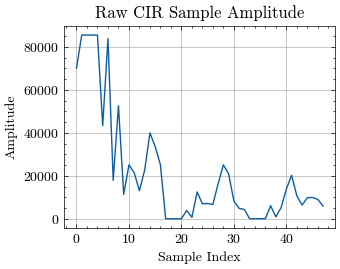

STAGE 1: Initial raw amplitude correlation alignment
   Using first frame as reference

STAGE 2: Frame-by-frame correlation with min-max normalization
------------------------------------------------------------
   Raw correlation shifts applied: mean=0.00, std=0.00
   Correlation power range: [1.10e+02, 1.14e+02]

STAGE 3: Outlier detection based on correlation power
------------------------------------------------------------
   Threshold: 7.86e+01
   Found 0 outlier frames based on raw correlation

STAGE 4: Interpolating outlier frames
------------------------------------------------------------
   No outliers to interpolate

STAGE 5: Derivative-based correlation alignment
------------------------------------------------------------
   Using derivative type: 2nd
   Using mean of first 1 frames as reference
   2nd derivative: shift range [-2.0, 3.0], corr range [6.82e+06, 1.49e+07]
   Final shift statistics: mean=0.92, std=0.50

Applying derivative-based shifts...

Detecting derivati

In [2]:
from cir_utils import *
from correlation_alignment import *
plt.style.use(['science', 'no-latex'])


def get_CIRs(file_path):
    """
    get_CIRs loads the CIRs from a log file of the embedded version of cherry-radar
    or from a data file created with the option -f of the linux version of cherry-radar.
    The log file may contain anything. The start of the CIR data must be prefixed by 'CIR:'.
    After 'CIR:', there is a comma separated list of complex numbers.
    For example:
    [00:04:35.392,761] <inf> qlog: CIR:-1+12j,69+19j,3231+540j,3231+1665j,3231-221j,...
    or
    CIR:-38+7j,139+14j,2714+579j,3231+3142j,3231+3231j,...
    Parameters:
        file_path (str): file path of the log file
    Returns:
        cirs_z (numpy.ndarray) : 2d complex numpy array containing the CIRs (slowtime, fasttime)
    """
    data = []
    with open(file_path, "r") as f:
        for line in f:
            match = re.search("^.*(CIR:)(.*)", line)
            if match is not None and match.group(1) == "CIR:":
                cir = np.fromstring(match.group(2), dtype="complex", sep=',')
                data.append(cir)
    cirs_z = np.array(data)
    print(f"{cirs_z.shape[0]} CIRs of {cirs_z.shape[1]} taps loaded from {file_path}.")
    return cirs_z

def extract_radar_data_pc_board(file_path: str) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Extract frame indices, sweep timestamps and complex sample data from a radar log file.

    Args:
        file_path: Path to the accumulator log text file.

    Returns:
        frame_indices: 1D array of frame indices (int64).
        timestamps: 1D array of sweep timestamps (int64).
        samples: 2D array of complex128 samples, shape (num_sweeps, samples_per_sweep).
    """
    with open(file_path, 'r') as f:
        content = f.read()

    # Extract all frame indices (FRAME N:)
    frame_pattern = r'FRAME\s+(\d+)\b'
    frame_indices = np.array([int(m) for m in re.findall(frame_pattern, content)], dtype=np.int64)

    # Extract all timestamps
    timestamp_pattern = r'ts=(\d+)'
    timestamps = np.array([int(m) for m in re.findall(timestamp_pattern, content)], dtype=np.int64)

    sweep_seq_num_pattern = r'seq=(\d+)'
    sweep_seq_nums = np.array([int(m) for m in re.findall(sweep_seq_num_pattern, content)], dtype=np.int64)

    # Extract Re and Ie arrays
    re_pattern = r'Re\s*=\s*\[([^\]]+)\]'
    ie_pattern = r'Im\s*=\s*\[([^\]]+)\]'

    re_matches = re.findall(re_pattern, content)
    ie_matches = re.findall(ie_pattern, content)

    if len(re_matches) != len(ie_matches):
        raise ValueError(f"Mismatch: {len(re_matches)} Re arrays vs {len(ie_matches)} Ie arrays")

    if len(re_matches) != len(timestamps):
        raise ValueError(f"Mismatch: {len(timestamps)} timestamps vs {len(re_matches)} sample arrays")

    if len(frame_indices) != len(timestamps):
        raise ValueError(f"Mismatch: {len(frame_indices)} frames vs {len(timestamps)} timestamps")
    
    if len(sweep_seq_nums) != len(timestamps):
        raise ValueError(f"Mismatch: {len(sweep_seq_nums)} sweep sequence numbers vs {len(timestamps)} timestamps")

    # Parse and combine into complex128 samples
    samples_list = []
    for re_str, ie_str in zip(re_matches, ie_matches):
        re_vals = np.array([int(x.strip()) for x in re_str.split(',') if x.strip()], dtype=np.float64)
        ie_vals = np.array([int(x.strip()) for x in ie_str.split(',') if x.strip()], dtype=np.float64)

        if len(re_vals) != len(ie_vals):
            raise ValueError(f"Mismatch in sample lengths: Re={len(re_vals)}, Ie={len(ie_vals)}")

        # Complex: real + j*imaginary
        complex_samples = re_vals + 1j * ie_vals
        samples_list.append(complex_samples)

    samples = np.array(samples_list, dtype=np.complex128)

    return frame_indices, timestamps, samples, sweep_seq_nums

def uniform_get_CIRs(file_path: str, discard_reading: int) -> np.ndarray:
    if file_path.endswith('.data'):
        rx_cir = get_CIRs(file_path)
    elif file_path.endswith('.txt'):
        rx_cir = extract_radar_data_pc_board(file_path)[2]
    else:
        raise ValueError("Unsupported file format. Use .data or .txt files.")
    if discard_reading > 0:
        rx_cir = rx_cir[discard_reading:, :]
    return rx_cir

# ===== Load CIR processing parameters via Hydra config =====

config = load_cir_config()
# print(OmegaConf.to_yaml(config))

INPUT_FOLDER = config.input_folder
INPUT_FILE = config.input_file
# INPUT_FILE = './pc_board_12bit_200Hz_moving.txt'

discard_reading = config.discard_reading
upsample_factor = config.upsample_factor

rx_cir = uniform_get_CIRs(os.path.join(INPUT_FOLDER, INPUT_FILE), discard_reading=0)[:, 0:]  # remove first 9 samples TX-RX leakage
CIR_SAMPLE = rx_cir.shape[1]
print('CIR sample size:', CIR_SAMPLE)

plt.plot(np.abs(rx_cir[100]))
plt.title('Raw CIR Sample Amplitude')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()
plt.close()

# ===== Upsample the CIR and align the data =====
zero_padded_num = config.zero_padded_num
zero_padded_rx_cir = np.zeros((rx_cir.shape[0], rx_cir.shape[1] + zero_padded_num * 2), dtype=complex)
zero_padded_rx_cir[:, zero_padded_num:zero_padded_num+rx_cir.shape[1]] = rx_cir
del rx_cir
rx_cir = zero_padded_rx_cir

# upsample the CIR by 64 using FFT
cir_upsampled = np.zeros((rx_cir.shape[0], rx_cir.shape[1] * upsample_factor), dtype=complex)
for i in range(rx_cir.shape[0]):
    X = np.fft.fft(rx_cir[i], n=rx_cir.shape[1])
    # zero-padding in the frequency domain
    X_upsampled = np.zeros(X.shape[0] * upsample_factor, dtype=complex)
    X_upsampled[:X.shape[0]//2] = X[:X.shape[0]//2]
    X_upsampled[-X.shape[0]//2:] = X[-X.shape[0]//2:]
    cir_upsampled[i] = np.fft.ifft(X_upsampled)[0:cir_upsampled.shape[1]] * upsample_factor


# Load alignment parameters from config
los_search_start = int((zero_padded_num + config.los_search_offset_start) * upsample_factor)
los_search_end = int((zero_padded_num + config.los_search_offset_end) * upsample_factor)
peak_win_start = zero_padded_num * upsample_factor
peak_win_end = (zero_padded_num + config.peak_win_offset_end) * upsample_factor

aligned_cir, shifts, combined_outliers = correlation_align_cir(
    cir_data=cir_upsampled, 
    los_search_start=los_search_start, 
    los_search_end=los_search_end,
    sg_window=config.savgol_window_length, sg_poly=config.savgol_polyorder,
    corr_factor=0.5,
    derivative_type='2nd',
    raw_corr_threshold=0.7,
    raw_corr_search_window=50,
    interpolate_outliers=True, visualize=False)

aligned_los_part = np.abs(aligned_cir[:, peak_win_start:peak_win_end])
peak_indices = np.argmax(aligned_los_part, axis=1)
los_index = peak_indices.mean() + peak_win_start
print("LOS index:", los_index, "Peak indices:", peak_indices[0:100])

# # Roll LoS index to 100
# los_diff = 3 * upsample_factor - los_index
# cir_aligned = np.roll(aligned_cir, int(np.round(los_diff)), axis=-1)
# los_index += los_diff
cir_aligned = aligned_cir


[7/7] Applying phase correction...


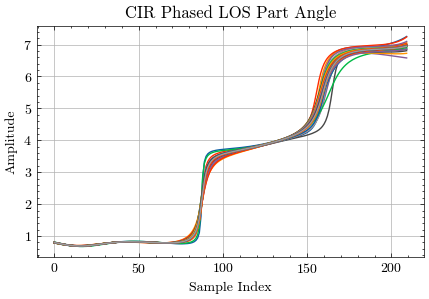

   Phase correction applied


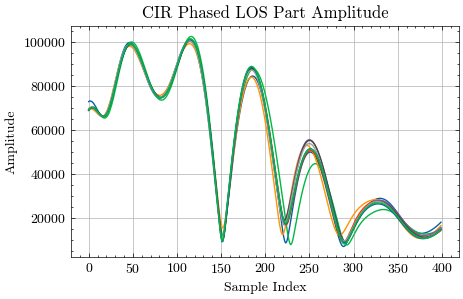

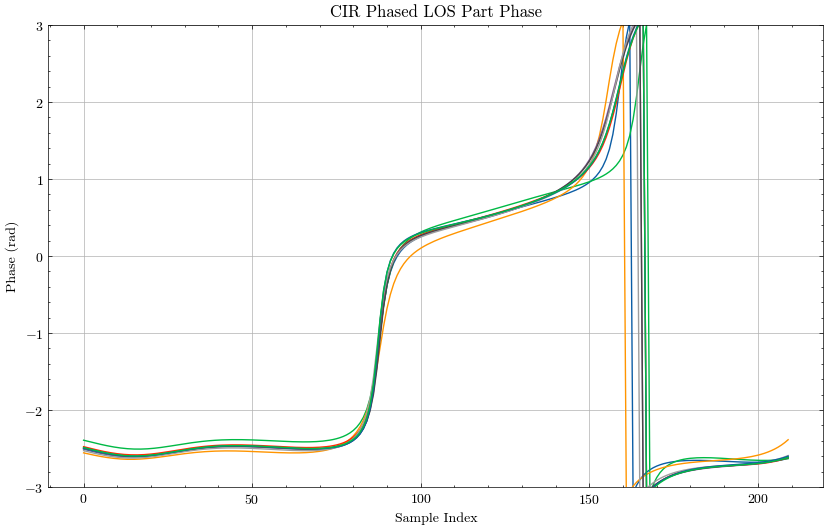

In [3]:
# Zero reference phase
print("\n[7/7] Applying phase correction...")
N, L = cir_aligned.shape
start = int((zero_padded_num + 2) * upsample_factor)
end = int((zero_padded_num + 5) * upsample_factor) + int(los_index)

cir_aligned_los_part = cir_aligned[..., start:end]
cir_aligned_los_part_phase = np.unwrap(np.angle(cir_aligned_los_part), axis=-1)

plt.figure(figsize=(5, 3))
for i in range(0, cir_aligned_los_part_phase.shape[0], 100):
    plt.plot((cir_aligned_los_part_phase[i]))
plt.title('CIR Phased LOS Part Angle')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

ref_phase = cir_aligned_los_part_phase.mean(axis=-1, keepdims=True)
cir_phased = cir_aligned * np.exp(-1j * ref_phase)
print(f"   Phase correction applied")

plt.figure(figsize=(5, 3))
for i in range(0, cir_phased.shape[0], 500):
    plt.plot(np.abs(cir_phased[i, 0:400]))
plt.title('CIR Phased LOS Part Amplitude')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(0, cir_phased.shape[0], 500):
    plt.plot((np.angle(cir_phased[i, start:end])))
plt.ylim(-3, 3)
plt.title('CIR Phased LOS Part Phase')
plt.xlabel('Sample Index')
plt.ylabel('Phase (rad)')
plt.grid()
plt.show()

# for i in range(0, cir_phased.shape[1], upsample_factor):
#     fig, ax = plt.subplots(figsize=(5, 3))
#     x = cir_phased[:, i].real
#     y = cir_phased[:, i].imag
#     ax.plot(x, y, '.')
#     ax.set_title(f'CIR Phased Scatter Plot at Sample {i}')
#     ax.set_xlabel('Real')
#     ax.set_ylabel('Imaginary')
#     ax.grid(True)
#     ax.set_aspect('equal', adjustable='box')
#     # make x/y limits symmetric for a square aspect with some margin
#     m = max(np.max(np.abs(x)), np.max(np.abs(y))) + 1e-12
#     ax.set_xlim(-m, m)
#     ax.set_ylim(-m, m)
#     plt.show()
#     plt.close()

2.2737367544323206e-13 4095

Processing with shift amount: -1


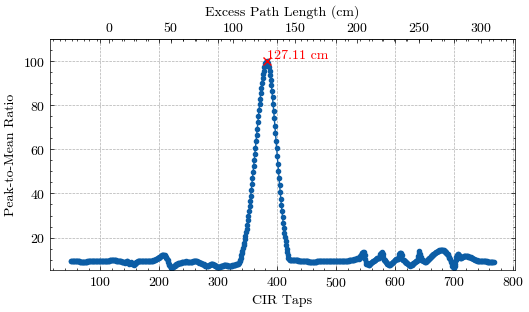

Max correlation index: 382
Max correlation value: 99.8647
Excess Path Length at max correlation: 127.10998751530309


In [6]:
def getCorrelationResults(cir_phased, los_index=los_index, upsample_factor=upsample_factor, pn_code_index=None, starting_idx=None, SHOW_FIG=None):
    tap_factor = 30.4589137328 / 2
    config = load_cir_config()

    if pn_code_index is None:
        corr_code = read_packed_kasami_h(config.pn_code)
    else:
        corr_code = read_packed_kasami_h(config.pn_code[pn_code_index])
    
    corr_code = 2 * corr_code - 1  # Convert to bipolar (-1, 1) format
    corr_code = corr_code - np.mean(corr_code)
    seq_len = len(corr_code)
    print(np.sum(corr_code), seq_len)

    if starting_idx is None:
        starting_idx = config.starting_idx
    shift_amounts = np.array(config.shift_amount)

    max_corr_list = np.zeros((len(shift_amounts), len(config.corr_indices)), dtype=np.float32)

    for i, shift_amount in enumerate(shift_amounts):
        print(f"\nProcessing with shift amount: {shift_amount}")
        if shift_amount == -1:
            cir_half = cir_phased
        else:
            cir_half = cir_phased[shift_amount::2]
        cir_eval = cir_half[starting_idx:starting_idx+seq_len, :].copy()
        cir_eval_mean = np.mean(cir_eval, axis=0)
        cir_eval -= cir_eval_mean
        assert len(cir_eval) >= len(corr_code), f"Length of cir_eval {len(cir_eval)} does not match length of corr_code {len(corr_code)}"
        if SHOW_FIG is None:
            SHOW_FIG = config.SHOW_FIG
        corr_indices = config.corr_indices

        offset = 0

        tap_variance_list = []
        mean_list = []
        for j, tap in enumerate(corr_indices):
            tap_variance_list.append(np.var(np.abs(cir_eval[:, tap])))
            mean_list.append(np.mean(np.abs(cir_eval[:, tap])))

            corr_power, rho, psr_f = detect_periodic_pn(cir_eval[:, tap], corr_code)
            max_corr_list[i, j] = calculate_pmr(corr_power, config.peak_wnd)

            if SHOW_FIG:
                plt.figure(figsize=(5, 3))
                plt.plot(cir_eval[:, tap].real, cir_eval[:, tap].imag, '.')
                plt.title(f"Constellation for tap {tap} (Excess Path Length: {(tap-los_index-offset)/upsample_factor*tap_factor:.2f} cm)")
                plt.xlabel('In-Phase')
                plt.ylabel('Quadrature')
                plt.grid()
                plt.show()
                plt.close()
            
                plt.figure(figsize=(5, 3))
                plt.plot(np.abs(cir_eval[100:1000, tap]), '.-')
                plt.title(f"CIR Amplitude for tap {tap} (Excess Path Length: {(tap-los_index-offset)/upsample_factor*tap_factor:.2f} cm)")
                plt.xlabel('Sample Index')
                plt.ylabel('CIR Amplitude')
                plt.margins(0.1, 0.1)
                plt.grid(True, linestyle='--')
                plt.show()
                plt.close()

                plt.figure(figsize=(5, 3))
                plt.plot(np.angle(cir_eval[100:1000, tap]), '.-')
                plt.title(f"CIR Phase for tap {tap} (Excess Path Length: {(tap-los_index-offset)/upsample_factor*tap_factor:.2f} cm)")
                plt.xlabel('Sample Index')
                plt.ylabel('CIR Phase (rad)')
                plt.margins(0.1, 0.1)
                plt.grid(True, linestyle='--')
                plt.show()
                plt.close()

                plt.figure(figsize=(5, 3))
                plt.plot(corr_power, '.-')
                plt.title(f"Correlation power for tap {tap} (Excess Path Length: {(tap-los_index-offset)/upsample_factor*tap_factor:.2f} cm)")
                plt.xlabel('Correlation Tap Index')
                plt.ylabel('Correlation Power')
                plt.margins(0.1, 0.1)
                plt.grid(True, linestyle='--')
                plt.xlim(np.argmax(corr_power)-config.peak_wnd, np.argmax(corr_power)+config.peak_wnd)
                plt.savefig(f"{INPUT_FILE}_tap_{tap}_si{starting_idx}_sa{shift_amount}.png", dpi=300)
                plt.show()
                plt.close()
                print(f"Max correlation for tap {tap}:")
                print(f"for real+imag: {np.max(corr_power):.2f}, max index: {np.argmax(corr_power)}, min index: {np.argmin(corr_power)}")

        # # min-max normalization
        # max_corr_list = (max_corr_list - np.min(max_corr_list)) / (np.max(max_corr_list) - np.min(max_corr_list))
        # max_corr_list -= np.mean(max_corr_list) 
        plt.figure(figsize=(6, 3))
        plt.plot(corr_indices, max_corr_list[i], marker='.', linestyle='-')
        # Set primary x-axis (bottom) for CIR Taps
        plt.xlabel('CIR Taps')

        # Create secondary x-axis (top) for Excess Path Length
        def excess_path_length(indices):
            return (np.array(indices) - los_index - offset) / upsample_factor * tap_factor

        ax = plt.gca()
        secax = ax.secondary_xaxis('top', functions=(excess_path_length, 
                                                    lambda x: (x / tap_factor) * upsample_factor + los_index + offset))
        secax.set_xlabel('Excess Path Length (cm)')
        plt.grid(True, linestyle='--')
        plt.xlabel('CIR Taps')
        plt.ylabel('Peak-to-Mean Ratio')
        plt.ylim(np.min(max_corr_list[i])*0.8, np.max(max_corr_list[i])*1.1)

        # mark the maximum point
        max_idx = int(np.argmax(max_corr_list[i]))
        plt.plot(corr_indices[max_idx], max_corr_list[i, max_idx], 'rx')  # highlight max point
        # add a text box showing the corresponding excess path length
        excess_length_at_max = excess_path_length(corr_indices[max_idx])
        plt.text(corr_indices[max_idx], max_corr_list[i, max_idx], f'{excess_length_at_max:.2f} cm', 
                verticalalignment='bottom', color='red')

        plt.savefig(f"{INPUT_FILE}_pmr.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        # Convert np.argmax(max_corr_list) to int for ListConfig indexing
        max_idx = int(np.argmax(max_corr_list[i]))
        print("Max correlation index:", corr_indices[max_idx])
        print("Max correlation value:", np.max(max_corr_list[i]))
        print("Excess Path Length at max correlation:", excess_path_length(corr_indices[max_idx]))
    
    # return the max_corr_list that has larger maximum value
    if max_corr_list.shape[0] == 1:
        return max_corr_list[0], corr_indices
    if np.max(max_corr_list[0]) >= np.max(max_corr_list[1]):
        return max_corr_list[0], corr_indices
    else:
        return max_corr_list[1], corr_indices

max_corr, corr_indices = getCorrelationResults(cir_phased, starting_idx=0, pn_code_index=0)

In [ ]:
max_corr_0, corr_indices = getCorrelationResults(cir_phased, starting_idx=0, pn_code_index=0)
max_corr_1, corr_indices = getCorrelationResults(cir_phased, starting_idx=0, pn_code_index=1)
max_corr_2, corr_indices = getCorrelationResults(cir_phased, starting_idx=0, pn_code_index=2)
max_corr_3, corr_indices = getCorrelationResults(cir_phased, starting_idx=0, pn_code_index=3)
max_corr_4, corr_indices = getCorrelationResults(cir_phased, starting_idx=0, pn_code_index=4)

five_tag_corr = np.array([max_corr_0, max_corr_1, max_corr_2, max_corr_3, max_corr_4])

In [ ]:
from palettable.cartocolors.diverging import Temps_5
colors = Temps_5.mpl_colors
plt.style.use(['science', 'grid', 'no-latex', 'high-contrast'])

# Create secondary x-axis (top) for Excess Path Length
def excess_path_length(indices):
    return (np.array(indices) - los_index - 0) / upsample_factor * 30.4589137328

plt.figure(figsize=(6, 3))
for i, max_corr in enumerate(five_tag_corr):
    # max_corr = (max_corr - np.min(max_corr)) / (np.max(max_corr) - np.min(max_corr))
    plt.plot(corr_indices, max_corr, linestyle='-', label=f'Tag {i}', color=colors[i], linewidth=2)
    # mark the maximum point
    max_idx = int(np.argmax(max_corr))
    plt.plot(corr_indices[max_idx], max_corr[max_idx], 'rx')  # highlight max point
    # add a text box showing the corresponding excess path length
    excess_length_at_max = excess_path_length(corr_indices[max_idx])
    plt.text(corr_indices[max_idx], max_corr[max_idx], f'{excess_length_at_max:.2f} cm', 
            verticalalignment='bottom', color='red')
# Set primary x-axis (bottom) for CIR Taps
plt.xlabel('CIR Taps')
ax = plt.gca()
secax = ax.secondary_xaxis('top', functions=(excess_path_length, 
                                            lambda x: (x / 30.4589137328) * upsample_factor + los_index + 0))
secax.set_xlabel('Excess Path Length (cm)')
plt.grid(True, linestyle='--')
plt.legend()
plt.xlabel('CIR Taps')
plt.ylabel('Peak-to-Mean Ratio')
plt.ylim(np.min(five_tag_corr)*0.8, np.max(five_tag_corr)*1.1)
# plt.ylim(-0.05, 1.1)
plt.savefig(f"{INPUT_FILE}_fivetag_pmr.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
from palettable.cartocolors.diverging import Temps_5
colors = Temps_5.mpl_colors
plt.style.use(['science', 'grid', 'no-latex', 'high-contrast'])

# Create secondary x-axis (top) for Excess Path Length
def excess_path_length(indices):
    return (np.array(indices) - los_index - 0) / upsample_factor * 30.4589137328

plt.figure(figsize=(6, 3))
for i, max_corr in enumerate(five_tag_corr):
    # max_corr = (max_corr - np.min(max_corr)) / (np.max(max_corr) - np.min(max_corr))
    plt.plot(corr_indices, max_corr, linestyle='-', label=f'Tag {i}', color=colors[i], linewidth=2)
    # mark the maximum point
    max_idx = int(np.argmax(max_corr))
    plt.plot(corr_indices[max_idx], max_corr[max_idx], 'rx')  # highlight max point
    # add a text box showing the corresponding excess path length
    excess_length_at_max = excess_path_length(corr_indices[max_idx])
    plt.text(corr_indices[max_idx], max_corr[max_idx], f'{excess_length_at_max:.2f} cm', 
            verticalalignment='bottom', color='red')
# Set primary x-axis (bottom) for CIR Taps
plt.xlabel('CIR Taps')
ax = plt.gca()
secax = ax.secondary_xaxis('top', functions=(excess_path_length, 
                                            lambda x: (x / 30.4589137328) * upsample_factor + los_index + 0))
secax.set_xlabel('Excess Path Length (cm)')
plt.grid(True, linestyle='--')
plt.legend()
plt.xlabel('CIR Taps')
plt.ylabel('Peak-to-Mean Ratio')
plt.ylim(np.min(five_tag_corr)*0.8, np.max(five_tag_corr)*1.1)
# plt.ylim(-0.05, 1.1)
plt.savefig(f"{INPUT_FILE}_fivetag_pmr.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()